In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


In [63]:
# Load the dataset
probes_df = pd.read_csv('../data/Catalog - Probes.csv')

# Function to create the 'Make_Model' identifier
def create_make_model(row):
    if row['Connection_Type'] == 'Cartridge':
        return f"{row['Manufacturer']} {row['Probe_Model']}*"
    else:
        return f"{row['Manufacturer']} {row['Probe_Model']}"

# Apply the function to each row
probes_df['Make_Model'] = probes_df.apply(create_make_model, axis=1)


print(f"Dataset shape: {probes_df.shape}\n")

probes_df.head()

Dataset shape: (43, 10)



,Manufacturer,Probe_Model,Connection_Type,Compatible_Systems,Array_Type,Frequency_Range,Applications,Description,Stock,Make_Model
0,ATL,C3,NaN,HDI 5000,Convex Array,3 MHz,"abdominal, general",The ATL C3 is a convex array ultrasound transd...,0,ATL C3
1,ATL,C4-2,NaN,HDI 5000,Convex Array,2-4 MHz,"abdominal, obstetric, gynecologic, general",The ATL C4-2 is a convex array ultrasound prob...,2,ATL C4-2
2,ATL,C5-2,NaN,"HDI 1500, HDI 3000, HDI 3500, HDI 5000",Convex Array,2-5 MHz,abdominal,The ATL C5-2 convex Array transducer is a vers...,7,ATL C5-2
3,ATL,C5-IVT,NaN,"UM9 HDI, HDI 1500, HDI 3000, HDI 3500, HDI 5000",Convex Array,4-6 MHz,"intracavitary, endovaginal, gynecological",The ATL C5-IVT convex linear ultrasound transd...,0,ATL C5-IVT
4,ATL,C7-4,NaN,"UM9 HDI, HDI 1500, HDI 3000, HDI 5000",Convex Array,4-7 MHz,"cardiac, vascular, general",The ATL C7-4 convex linear ultrasound transduc...,0,ATL C7-4


In [68]:
# Count number of unique probe models and manufacturers
print(f"\nUnique Probe Models: {probes_df['Make_Model'].nunique()}")
print(f"Unique Manufacturers: {probes_df['Manufacturer'].nunique()}")

# Count number of ultrasound systems
compatability_df = probes_df.copy()
compatability_df['Compatible_Systems'] = compatability_df['Compatible_Systems'].str.split(',')
compatability_df = compatability_df.explode('Compatible_Systems')
compatability_df['Compatible_Systems'] = compatability_df['Compatible_Systems'].str.strip()
print(f"Unique Compatible Systems: {compatability_df['Compatible_Systems'].nunique()}")

# Count overlapping models between different manufacturers
overlapping_models = probes_df.groupby('Probe_Model').filter(lambda x: x['Manufacturer'].nunique() > 1)
print(f"Number of overlapping Probe Models between different manufacturers: {overlapping_models['Probe_Model'].nunique()}")
print(overlapping_models[['Make_Model']].drop_duplicates())

# Count of overlapping models within the same manufacturer
same_maker_overlap = probes_df.groupby(['Manufacturer', 'Probe_Model']).filter(lambda x: len(x) > 1)
print(f"\nNumber of overlapping Probe Models within the same manufacturer: {same_maker_overlap.groupby('Manufacturer')['Probe_Model'].nunique().sum()}")
print(same_maker_overlap[['Manufacturer', 'Probe_Model', 'Connection_Type']].drop_duplicates())




Unique Probe Models: 43
Unique Manufacturers: 4
Unique Compatible Systems: 39
Number of overlapping Probe Models between different manufacturers: 2
       Make_Model
2        ATL C5-2
5       ATL C8-4v
26   Philips C5-2
27  Philips C8-4v

Number of overlapping Probe Models within the same manufacturer: 3
   Manufacturer Probe_Model Connection_Type
24      Philips        C5-1       Cartridge
25      Philips        C5-1             NaN
30      Philips       L12-3       Cartridge
31      Philips       L12-3             NaN
35      Philips        S4-2       Cartridge
36      Philips        S4-2             NaN


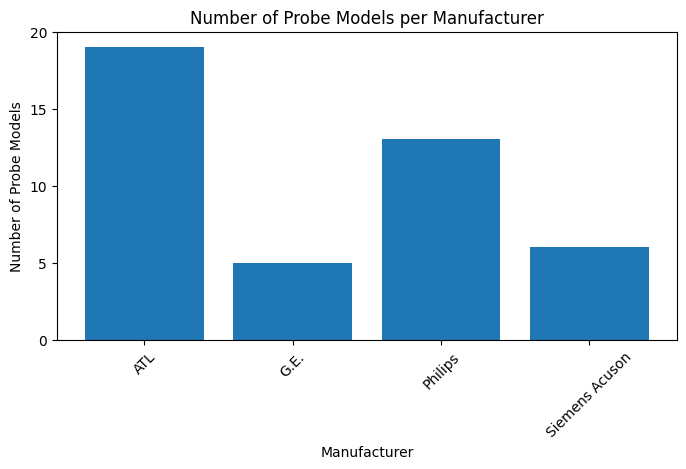

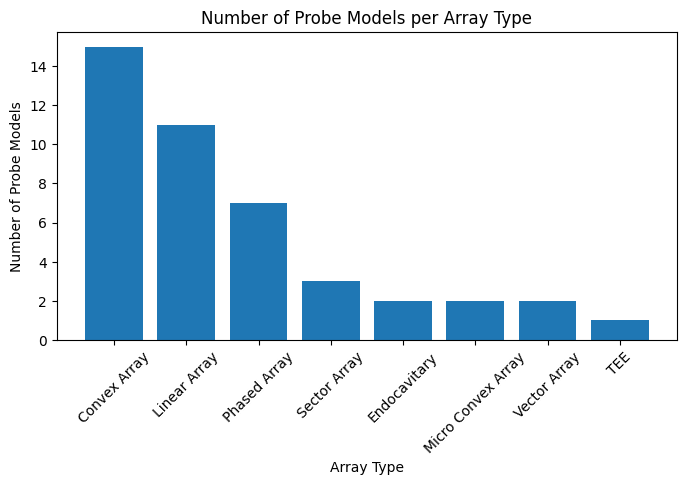

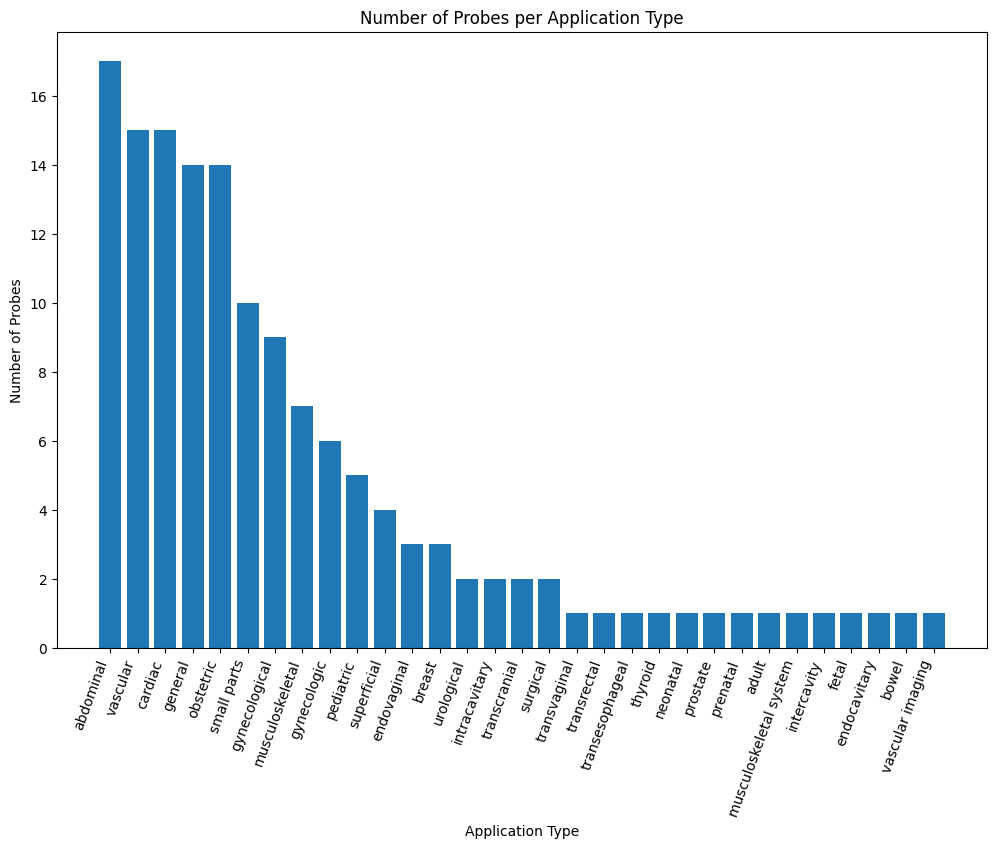

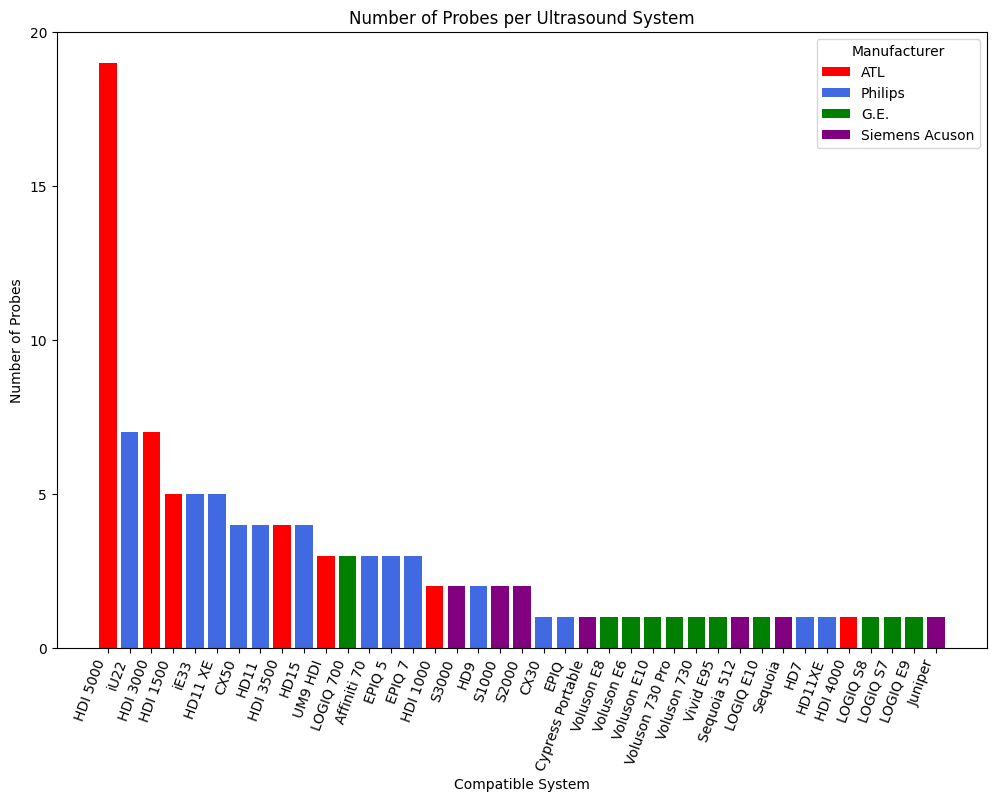

In [70]:
# Function to plot number of Probe Models per Manufacturer
def plot_probe_models_per_manufacturer(df):
    """Plot the number of probe models per manufacturer."""
    df_copy = df.copy()
    data = df_copy.groupby('Manufacturer')['Make_Model'].nunique().reset_index()
    data.columns = ['Manufacturer', 'Number of Probe Models']
    plt.figure(figsize=(8, 4))
    plt.bar(data['Manufacturer'], data['Number of Probe Models'])
    plt.xticks(rotation=45, ha='center')
    plt.xlabel('Manufacturer')
    plt.ylabel('Number of Probe Models')
    plt.title('Number of Probe Models per Manufacturer')
    max_value = data['Number of Probe Models'].max()
    plt.yticks(range(0, max_value + 5, 5))
    plt.show()

# Function to plot number of Probe Models per Array Type
def plot_probe_models_per_array_type(df):
    """Plot the number of probe models per array type."""
    df_copy = df.copy()
    data = df_copy.groupby('Array_Type')['Make_Model'].nunique().reset_index()
    data.columns = ['Array_Type', 'Number of Probe Models']
    data = data.sort_values(by='Number of Probe Models', ascending=False)
    plt.figure(figsize=(8, 4))
    plt.bar(data['Array_Type'], data['Number of Probe Models'])
    plt.xticks(rotation=45, ha='center')
    plt.xlabel('Array Type')
    plt.ylabel('Number of Probe Models')
    plt.title('Number of Probe Models per Array Type')
    plt.show()

# Function to plot number of Probes per Compatible System
def plot_probes_per_compatible_system(df):
    """Plot the number of probes per compatible system, colored by manufacturer.
    Each system is treated as a separate entry on the x-axis."""
    df_copy = df.copy()
    df_copy['Compatible_Systems'] = df_copy['Compatible_Systems'].str.split(',')
    df_exploded = df_copy.explode('Compatible_Systems')
    df_exploded['Compatible_Systems'] = df_exploded['Compatible_Systems'].str.strip()

    # Count the number of probes for each compatible system
    data = df_exploded.groupby('Compatible_Systems')['Make_Model'].count().reset_index()
    data.columns = ['Compatible_Systems', 'Number of Probes']
    data = data.sort_values(by='Number of Probes', ascending=False)

    # Map each compatible system to its corresponding manufacturer
    manufacturer_map = df_exploded.groupby('Compatible_Systems')['Manufacturer'].apply(lambda x: x.mode()[0])
    manufacturer_colors = {'ATL': 'red', 'Philips': 'royalblue', 'G.E.': 'green', 'Siemens Acuson': 'purple'}
    colors = [manufacturer_colors.get(manufacturer_map[system], 'black') for system in data['Compatible_Systems']]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(data['Compatible_Systems'], data['Number of Probes'], color=colors)
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Compatible System')
    plt.ylabel('Number of Probes')
    plt.title('Number of Probes per Ultrasound System')
    max_value = data['Number of Probes'].max()
    plt.yticks(range(0, max_value + 5, 5))

    # Create a legend for the manufacturers
    legend_elements = [Patch(facecolor=manufacturer_colors[man], label=man) for man in manufacturer_colors]
    plt.legend(handles=legend_elements, loc='upper right', title="Manufacturer")

    plt.show()


# Function to plot number of Probes per Application Type
def plot_probes_per_application_type(df):
    """Plot the number of probes per application type."""
    df_copy = df.copy()
    df_copy['Applications'] = df_copy['Applications'].str.split(',')
    df_exploded = df_copy.explode('Applications')
    df_exploded['Applications'] = df_exploded['Applications'].str.strip()
    data = df_exploded.groupby('Applications')['Make_Model'].count().reset_index()
    data.columns = ['Application Type', 'Number of Probes']
    data = data.sort_values(by='Number of Probes', ascending=False)
    plt.figure(figsize=(12, 8))
    plt.bar(data['Application Type'], data['Number of Probes'])
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Application Type')
    plt.ylabel('Number of Probes')
    plt.title('Number of Probes per Application Type')
    plt.show()

plot_probe_models_per_manufacturer(probes_df)
plot_probe_models_per_array_type(probes_df)
plot_probes_per_application_type(probes_df)
plot_probes_per_compatible_system(probes_df)